## Demo#2 - Machine Learning Pipeline for Stock Price Movement Prediction

After Demo #1, we can retrieve the stock indicator features back from the SQL database. The stock indicator features can be used to predict the stock price momentum trend.

This notebook will cover the follow parts:
* [1.) Retrieving Stock Data from SQL Database](#1)
* [2.) Train and Test on the 10-Year Stock Data](#2)
* [3.) Simulate Stock Returns for the Last 2-Years](#3)

In [315]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

<a id="1"></a>
## 1.) Retrieving Stock Data from SQL Database

Using SQLite and the sqlalchemy library, we can retrieve the stock indicator features as well as closing price, date, and buy signal labels

### Dataframe to SQL

In [336]:
from sqlalchemy import create_engine

db_name = 'All_stocks.sql'
db = create_engine('sqlite:///' + db_name)
conn = db.connect()

Let's check which stock data tables are available in the SQL database first

In [337]:
conn.execute("""
SELECT name FROM sqlite_master 
WHERE type = 'table' AND name NOT LIKE 'sqlite_%';
""").fetchall()

[('SPY_LogitReg',), ('Testing123',)]

In [338]:
data = pd.read_sql("SELECT * FROM SPY_LogitReg", conn)
data.drop(['index'], inplace = True, axis = 1)
data['Date'] = data['Date'].str.replace('00:00:00.000000','')

In [340]:
conn.close()

<a id="2"></a>
## 2.) Train and Test on the 10-Year Stock Data

Since there are 10-years worth of stock data, by training on the data from the first 8-years, we can see how well the model will predict the stock price trends of the last 2-years.
<Br>This is essentially a 80:20 (train:test) split.

In [260]:
#Train on the first 8-years (~80% of data)
length = int(len(data)*0.8)

x_train = data.iloc[0:length,0:-3].values
y_train = data.iloc[0:length, -1].values

x_test = data.iloc[length:,0:-3].values
y_test = data.iloc[length:, -1].values

Scaling the data is usually necessary since every feature has varying size and degree of values.

In [261]:
train_scaler = StandardScaler()
scaled_x_train = train_scaler.fit_transform(x_train)
scaled_x_test = train_scaler.transform(x_test)

In [262]:
# from sklearn.ensemble import RandomForestClassifier
# reg = RandomForestClassifier(n_estimators=150, n_jobs=-1,
#                             min_samples_split =50, random_state = 42)

In [263]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(max_iter = 10000, tol=0.0001, C=1, random_state = 42, n_jobs = -1)

In [264]:
reg.fit(scaled_x_train,y_train)

LogisticRegression(C=1, max_iter=10000, n_jobs=-1, random_state=42)

In [265]:
y_pred = reg.predict(scaled_x_test)

<a id="3"></a>
## 3.) Simulate Stock Returns for the Last 2-Years

Now that we have the prediction for the most recent 20% of the data (last 2-years), we can use these predicted price trend signals to simulate the investment returns if one were to follow these predicted signals.

In order to do this, first the predicted sell signal must be obtained as well (which is just the inverse of the buy predicted signal)

In [266]:
test = data.iloc[length:]
test['buy_pred_sig'] = y_pred
test['sell_pred_sig'] = abs(y_pred-1)

In [267]:
test.reset_index(inplace = True, drop = True)

In order to simulate the stock returns, the last data point (yesterday's stock signal) must be set to "sell" to calculate the total returns as if the stock was sold yesterday.

In [268]:
test.loc[test.shape[0]-1, 'buy_pred_sig']= 0
test.loc[test.shape[0]-1, 'sell_pred_sig']= 1

In [269]:
test['Buy_price'] = test['buy_pred_sig']*test['Close']
test['Sell_price'] = test['sell_pred_sig']*test['Close']
test

,RSI_19,Stochastic_7,RSI_18,ema_slope_37,Will_R_81,ema_slope_33,ema_slope_7,Close,Date,buy_sig,buy_pred_sig,sell_pred_sig,Buy_price,Sell_price
0,66.828795,0.936275,61.796407,1,-4.750499,1,1,281.99,2018-09-21,0.0,1.0,0.0,281.99,0.00
1,58.040216,0.708333,57.680631,1,-8.463074,1,1,281.06,2018-09-24,0.0,1.0,0.0,281.06,0.00
2,56.708712,0.644608,52.046944,1,-9.500998,1,1,280.80,2018-09-25,0.0,1.0,0.0,280.80,0.00
3,49.086985,0.108949,53.153493,1,-12.854291,1,0,279.96,2018-09-26,0.0,1.0,0.0,279.96,0.00
4,55.687546,0.340611,55.656795,1,-9.740519,1,1,280.74,2018-09-27,0.0,1.0,0.0,280.74,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,65.954413,1.000000,73.744186,1,-0.683405,1,1,338.64,2020-08-18,1.0,1.0,0.0,338.64,0.00
480,70.724207,0.758562,75.271479,1,-3.509289,1,1,337.23,2020-08-19,1.0,1.0,0.0,337.23,0.00
481,76.048904,0.801105,74.244400,1,-1.961073,1,1,338.28,2020-08-20,1.0,1.0,0.0,338.28,0.00
482,75.202488,1.000000,80.305535,1,-0.353305,1,1,339.48,2020-08-21,1.0,1.0,0.0,339.48,0.00


In [270]:
buy = False

if test['Buy_price'].iloc[0] > 1:
    buy_sell_index = [(0,'Buy', test['Buy_price'].iloc[0])]
else:
    buy_sell_index = [(0,'Buy', test['Sell_price'].iloc[0])]
    
for i in range(1,len(test.index)):
    
    #Looks for two buy and two sell indicators in a row
    #Better safe than sorry, so sell when see first red, and buy when see 2nd green
    if buy == False:
        change = test['Buy_price'].iloc[i] - test['Buy_price'].iloc[i-1]
#         if change == 0:
#             if test['Sell_price'].iloc[i-1] != 0:
        if abs(change) == test['Buy_price'].iloc[i-1]:
            if test['Sell_price'].iloc[i-1] == 0:
                buy_sell_index.append((i, 'Sell', test['Sell_price'].iloc[i]))
                buy = True #Means sell and now looking for entry price to buy

    elif buy == True:
        change = test['Sell_price'].iloc[i] - test['Sell_price'].iloc[i-1]
      #  if change == 0:
       #     if test['Buy_price'].iloc[i-1] != 0:
        if abs(change) == test['Sell_price'].iloc[i-1]:
            if test['Buy_price'].iloc[i-1] == 0:
                buy_sell_index.append((i,'Buy', test['Buy_price'].iloc[i]))
                buy = False #Means sell and now looking for entry price to buy

In [271]:
simulator = pd.DataFrame(buy_sell_index)
simulator.columns = ['index', 'buy-sell','price']

Calculates the price change from simulation as well as total percent change

In [272]:
price_change = []
percent_change = []
for i in range(1, len(simulator.index), 2):
    change = simulator['price'].iloc[i] - simulator['price'].iloc[i-1]
    price_change.append(change)
    percent_change.append(100*change/simulator['price'].iloc[i-1])

In [273]:
total = 100
for i in percent_change:
    total = total*(i/100)+ total
total = total - 100
total

49.19031077772371

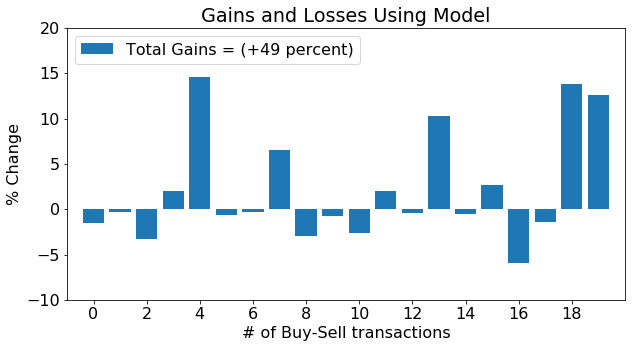

In [312]:
plt.figure(figsize = (10, 5))
plt.bar(np.arange(len(percent_change)), percent_change, label = 'Total Gains = (+%s percent)'%(int(total)))
plt.title('Gains and Losses Using Model')
plt.xlabel('# of Buy-Sell transactions')
plt.ylabel('% Change')
plt.legend(loc='upper left')
plt.xlim(-1,20)
plt.xticks(np.arange(0,20,2))
plt.ylim(-10,20)
#plt.savefig('SPY_2Years.jpg')

In [277]:
#Can use confusion matrix to get accuracy score and false positives/negatives

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_buy)
cm

array([[ 90,  64],
       [ 19, 311]], dtype=int64)

In [278]:
#Test accuracy
accuracy = 100*(cm[0][0]+cm[1][1])/y_test.shape[0]
accuracy

82.85123966942149

In [279]:
test.set_index('Date', inplace=True)

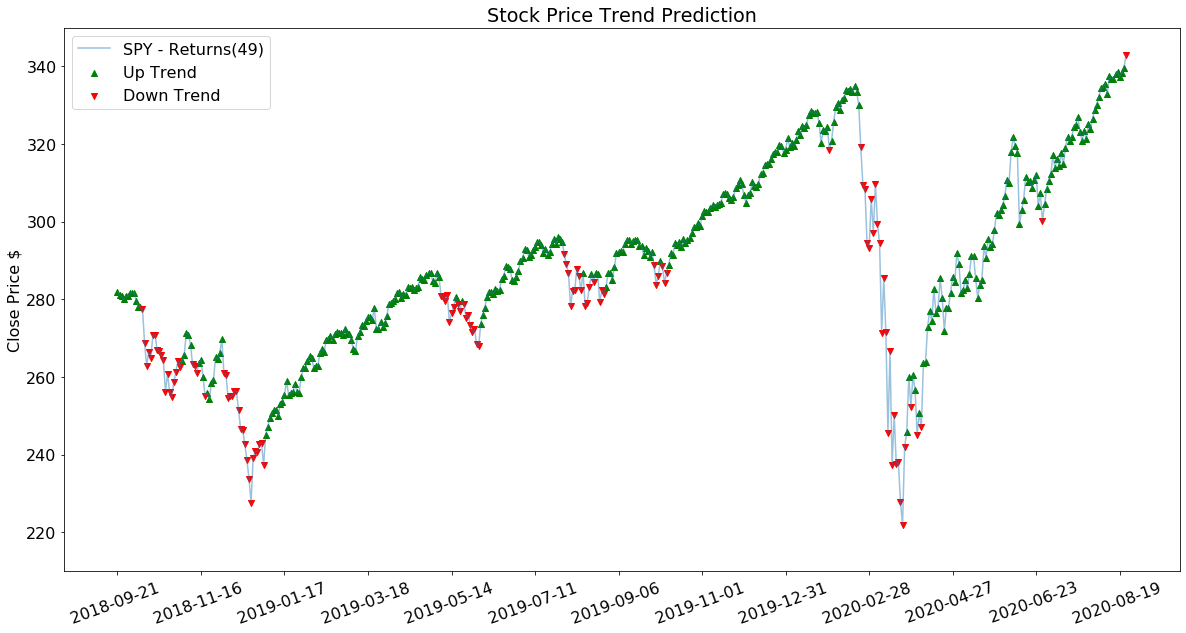

In [313]:
plt.figure(figsize = (20, 10))
plt.plot(test['Close'], label = 'SPY - Returns(%d)'%total, alpha = 0.45)
#Plot additional scatter points for buy and sell signals

plt.scatter(test.index, test['Buy_price'], label ='Up Trend', marker = '^', color = 'green')
plt.scatter(test.index, test['Sell_price'], label ='Down Trend', marker = 'v', color = 'red')
plt.title('Stock Price Trend Prediction')
#plt.xlabel('# of Days')
#plt.yscale("log")
plt.xticks(np.arange(0,len(test),40), rotation=20)
plt.ylim(210,350)
#plt.ylim(100, 400)

plt.ylabel('Close Price $')
plt.legend(loc='upper left')
plt.rcParams.update({'font.size': 16})

#plt.savefig('SPY_2Years_Plot.jpg')
plt.show()